# Votes analysis

Import data

In [165]:
import pandas as pd

file_name = "votes.csv"
data = pd.read_csv(file_name)

## Data summary

In [166]:
print(data.describe())

       Whats is your age?  demographic_time  contiguous_box_plots_time  \
count           19.000000         20.000000                  20.000000   
mean            26.000000      46856.050000               30930.750000   
std              9.643651      54493.409828               42748.548427   
min             21.000000       6618.000000                 907.000000   
25%             22.000000      16337.250000                6052.250000   
50%             22.000000      22576.000000               13518.500000   
75%             23.000000      38066.250000               41563.500000   
max             50.000000     197050.000000              150686.000000   

       contiguous_md_plots_time  contiguous_violin_plots_time  \
count                  20.00000                     20.000000   
mean                10215.30000                   8208.550000   
std                 11756.13388                  10117.299699   
min                   578.00000                    438.000000   
25%     

## Numerical summary

In [167]:
# keep only numerical columns
numerical_data = data.select_dtypes(include=['number'])
numerical_data.describe()

,Whats is your age?,demographic_time,contiguous_box_plots_time,contiguous_md_plots_time,contiguous_violin_plots_time,contiguous_bean_plots_time,ridgeline_plots_time,contiguous_d_heatmap_plot_time,continuous_colormap_plus_time,overlapping_box_plots_time,...,arc_diagram_plus_vs_overlapping_box_plots_time,arc_diagram_plus_vs_overlapping_md_plots,arc_diagram_plus_vs_overlapping_md_plots_time,arc_diagram_plus_vs_overlapping_violin_plots,arc_diagram_plus_vs_overlapping_violin_plots_time,arc_diagram_plus_vs_overlapping_bean_plots,arc_diagram_plus_vs_overlapping_bean_plots_time,arc_diagram_plus_vs_radial_edge_bundling,arc_diagram_plus_vs_radial_edge_bundling_time,Unnamed: 347
count,19.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.0000,20.000000,20.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,26.000000,46856.050000,30930.750000,10215.30000,8208.550000,4926.950000,7715.350000,3938.7500,5621.450000,10830.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,9.643651,54493.409828,42748.548427,11756.13388,10117.299699,5476.804557,10063.146799,3757.5793,8905.795384,25689.014754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,21.000000,6618.000000,907.000000,578.00000,438.000000,332.000000,560.000000,448.0000,390.000000,446.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,22.000000,16337.250000,6052.250000,2373.50000,1666.500000,1122.000000,1451.750000,987.5000,1150.750000,1294.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,22.000000,22576.000000,13518.500000,6623.00000,3222.500000,1883.000000,3614.000000,2893.5000,2069.500000,4089.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,23.000000,38066.250000,41563.500000,13051.25000,13053.500000,8742.500000,10626.500000,6179.5000,4757.250000,6793.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,50.000000,197050.000000,150686.000000,44056.00000,38815.000000,16600.000000,41320.000000,14154.0000,32778.000000,117442.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [168]:

columns_names = list(data.columns)
columns_names_vs = list(filter(lambda e : e.__contains__("_vs_") and not e.__contains__("time"), columns_names))
#print(columns_names_vs)

solutions_names = list(set([e.split("_vs_")[0] for e in columns_names_vs] + [e.split("_vs_")[1] for e in columns_names_vs]))
solutions_names.sort()
#print(solutions_names)



columns_names_vs_times = [e + "_time" for e in columns_names_vs]
total_time = data[columns_names_vs_times].sum(axis=0).sum()
print("Total time : ", total_time)
"""
vote_data = data[columns_names_vs]
# count the number of each value for each column
count = vote_data.apply(pd.value_counts)

count = count.fillna(0)
#print(count)
#shape of the count
#print(count.shape)

dist_matrix = pd.DataFrame(index=solutions_names, columns=solutions_names)
dist_matrix = dist_matrix.fillna(0)

#print(dist_matrix)

for duel in count.columns:
    #print(duel)
    for index, value in count[duel].iteritems():
        if value == 0:
            continue
        #print(index, value)
        sol1, sol2 = duel.split("_vs_")
        if index == sol1:
            dist_matrix.loc[sol1, sol2] += 1
        elif index == sol2:
            dist_matrix.loc[sol2, sol1] += 1
        else:   # Equal
            dist_matrix.loc[sol1, sol2] += 1/2
            dist_matrix.loc[sol2, sol1] += 1/2

print(dist_matrix)

"""

Total time :  3470078.0


'\nvote_data = data[columns_names_vs]\n# count the number of each value for each column\ncount = vote_data.apply(pd.value_counts)\n\ncount = count.fillna(0)\n#print(count)\n#shape of the count\n#print(count.shape)\n\ndist_matrix = pd.DataFrame(index=solutions_names, columns=solutions_names)\ndist_matrix = dist_matrix.fillna(0)\n\n#print(dist_matrix)\n\nfor duel in count.columns:\n    #print(duel)\n    for index, value in count[duel].iteritems():\n        if value == 0:\n            continue\n        #print(index, value)\n        sol1, sol2 = duel.split("_vs_")\n        if index == sol1:\n            dist_matrix.loc[sol1, sol2] += 1\n        elif index == sol2:\n            dist_matrix.loc[sol2, sol1] += 1\n        else:   # Equal\n            dist_matrix.loc[sol1, sol2] += 1/2\n            dist_matrix.loc[sol2, sol1] += 1/2\n\nprint(dist_matrix)\n\n'

In [169]:
import math
import pandas as pd

dist_matrix = pd.DataFrame(index=solutions_names, columns=solutions_names)
dist_matrix = dist_matrix.fillna(0)

for vs in columns_names_vs:
    # Create a DataFrame from the two columns
    columns = pd.DataFrame({
        'vs': data[vs],
        'time': data[vs + "_time"]
    })
    
    columns.dropna(axis=0, inplace=True)

    sol1, sol2 = vs.split("_vs_")
    for id, row in columns.iterrows():        
        if row['vs'] == 0:
            continue
        
        if row['time'] == None or row['time'] == 0:
            weight = 0
        else:
            weight = math.log(row['time'])# / math.log(total_time)
            #weight = row['time'] / total_time
        #weight = 1

        if row['vs'] == sol1:
            dist_matrix.loc[sol1, sol2] += 1 * weight
        elif row['vs'] == sol2:
            dist_matrix.loc[sol2, sol1] += 1 * weight
        else:   # Equal
            dist_matrix.loc[sol1, sol2] += 1/2 * weight
            dist_matrix.loc[sol2, sol1] += 1/2 * weight


In [170]:
dist_matrix

,arc_diagram_plus,contiguous_bean_plots,contiguous_box_plots,contiguous_d_heatmap_plot,contiguous_md_plots,contiguous_violin_plots,continuous_colormap_plus,overlapping_bean_plots,overlapping_box_plots,overlapping_md_plots,overlapping_violin_plots,radial_edge_bundling,ridgeline_plots
arc_diagram_plus,0.000000,22.090077,34.363008,39.067640,18.646465,16.292123,19.269916,37.747117,20.351798,28.525518,40.808654,25.796518,20.413933
contiguous_bean_plots,26.531760,0.000000,14.710515,40.156504,22.841750,30.329353,31.388148,14.732884,19.396949,40.318728,20.071373,29.534403,26.939651
contiguous_box_plots,32.742672,86.405554,0.000000,81.500659,79.398788,94.425986,39.944359,40.835482,60.764795,45.013791,45.594112,30.937920,43.946845
contiguous_d_heatmap_plot,14.509204,36.135830,20.595176,0.000000,29.646233,23.313712,13.396943,39.023872,28.659024,19.889449,19.373430,37.052107,0.000000
contiguous_md_plots,17.275889,65.636094,41.584856,69.524632,0.000000,45.710884,24.172144,41.636791,86.720184,46.129768,53.524381,22.634311,24.125886
contiguous_violin_plots,7.615298,46.056603,15.604766,30.154935,20.661371,0.000000,24.302475,16.553109,30.432314,45.467727,3.684800,28.397020,8.758884
continuous_colormap_plus,26.282978,56.528446,28.907586,70.533333,37.184112,30.270351,0.000000,31.704905,54.234024,40.759185,74.502322,43.451429,40.523692
overlapping_bean_plots,10.395686,31.425274,14.203740,26.541694,41.455887,25.358362,13.842843,0.000000,33.704571,32.036387,30.946990,33.638224,7.185277
overlapping_box_plots,13.204472,25.500409,3.796939,37.614960,10.904799,16.197772,6.928682,30.078279,0.000000,25.075358,29.358368,46.868191,24.292805
overlapping_md_plots,14.692181,31.883063,19.836301,27.405345,8.549854,44.191641,14.152743,32.946711,32.928497,0.000000,7.470443,39.500165,12.770784


## Bradley-Terry

In [171]:
# bradley-terry model
import numpy as np
import scipy.optimize as opt

def bradley_terry_model(matrix, n):
    nb_solution = matrix.shape[0]
    p = np.ones(nb_solution)
    for _ in range(n):
        #print(p)
        p = _bradley_terry_model(matrix, p)
    
    return p

def _bradley_terry_model(matrix, p):
    nb_solution = matrix.shape[0]
    next_p = np.zeros(nb_solution)
    for i in range(nb_solution):
        nom = 0
        denom = 0
        for j in range(nb_solution):
            if i == j:
                continue
            nom += matrix.iloc[i][j] * p[j] / (p[i] + p[j])
            denom += matrix.iloc[j][i] / (p[i] + p[j])

        p[i] = nom / denom
    
    # normalize p with geometric mean
    geometric_mean = 1
    for e in p:
        geometric_mean *= e
    geometric_mean = geometric_mean ** (1/nb_solution)
    
    p = p / geometric_mean
    
    return p

# test
test = [[0, 2, 0, 1], [3, 0, 5, 0], [0, 3, 0, 1], [4, 0, 3, 0]]
test = pd.DataFrame(test)

print(test)
p = bradley_terry_model(test, 1)
print(p)

   0  1  2  3
0  0  2  0  1
1  3  0  5  0
2  0  3  0  1
3  4  0  3  0
[0.51637379 1.41260876 0.67160933 2.04125468]


In [172]:
p = bradley_terry_model(dist_matrix, 100)
print(p)

# transform p into a dataframe and add the name of the solution
p = pd.DataFrame(p, index=solutions_names, columns=["score"])
p = p.sort_values(by="score", ascending=False)
print(p)

[1.91394953 0.64509575 2.77659956 0.64146924 1.52463686 0.67249062
 1.96668237 0.79416806 0.63497283 0.66193272 0.73900141 0.31645995
 2.88884307]
                              score
ridgeline_plots            2.888843
contiguous_box_plots       2.776600
continuous_colormap_plus   1.966682
arc_diagram_plus           1.913950
contiguous_md_plots        1.524637
overlapping_bean_plots     0.794168
overlapping_violin_plots   0.739001
contiguous_violin_plots    0.672491
overlapping_md_plots       0.661933
contiguous_bean_plots      0.645096
contiguous_d_heatmap_plot  0.641469
overlapping_box_plots      0.634973
radial_edge_bundling       0.316460


## Graph display using concordance 

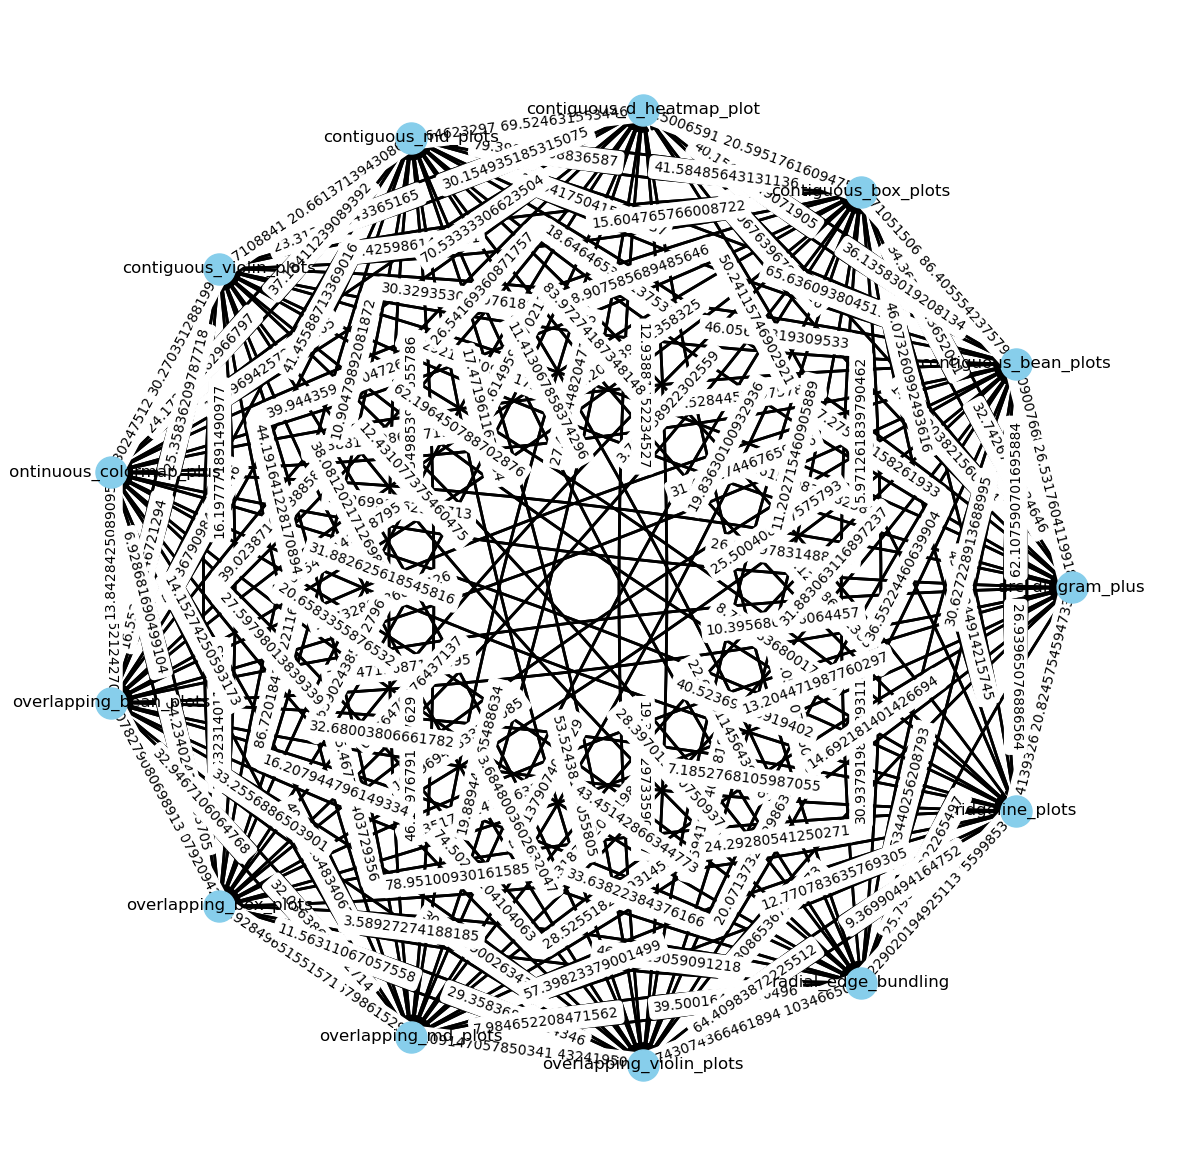

In [173]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming solutions_names and dist_matrix are defined properly

G = nx.MultiDiGraph()  # Use MultiDiGraph to allow multiple directed edges between nodes

threshold = 2

for i in solutions_names:
    for j in solutions_names:
        if dist_matrix.loc[i, j] >= threshold:
            # Add multiple directed edges between nodes
            G.add_edge(i, j, weight=dist_matrix.loc[i, j])
        if dist_matrix.loc[j, i] >= threshold:
            G.add_edge(j, i, weight=dist_matrix.loc[j, i])  # Add edge in reverse direction

# Specify a layout algorithm
# pos = nx.spring_layout(G)
# circular layout
pos = nx.circular_layout(G)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size as needed

# Draw nodes
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=500, node_color="skyblue")

curved_edges = [(u, v) for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, edgelist=curved_edges, ax=ax, width=2, arrows=True, connectionstyle='arc3, rad=0.05')

# Draw edge labels with offset
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, label_pos=0.3)

# Draw node labels
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12, font_color="black")

# Show the plot
plt.axis('off')  # Turn off axis
plt.show()


In [174]:
import copy


def get_kernel(G: nx.MultiDiGraph):
    # Create a new directed graph
    G2 = copy.deepcopy(G)

    while True:
        # remove all nodes with out-degree equal to 0 and in-degree not equal to 0
        nodes_to_remove = [node for node in G2.nodes() if G2.out_degree(node) == 0 and G2.in_degree(node) != 0]
        
        if len(nodes_to_remove) == 0:
            break
        
        G2.remove_nodes_from(nodes_to_remove)

    return G2


def get_kernel(G: nx.MultiDiGraph):
    # Create a new directed graph
    G2 = copy.deepcopy(G)

    while True:
        # remove all nodes with out-degree equal to 0 and in-degree not equal to 0
        nodes_to_remove = [node for node in G2.nodes() if G2.out_degree(node) == 0 and G2.in_degree(node) != 0]
        
        if len(nodes_to_remove) == 0:
            break
        
        G2.remove_nodes_from(nodes_to_remove)

    return G2

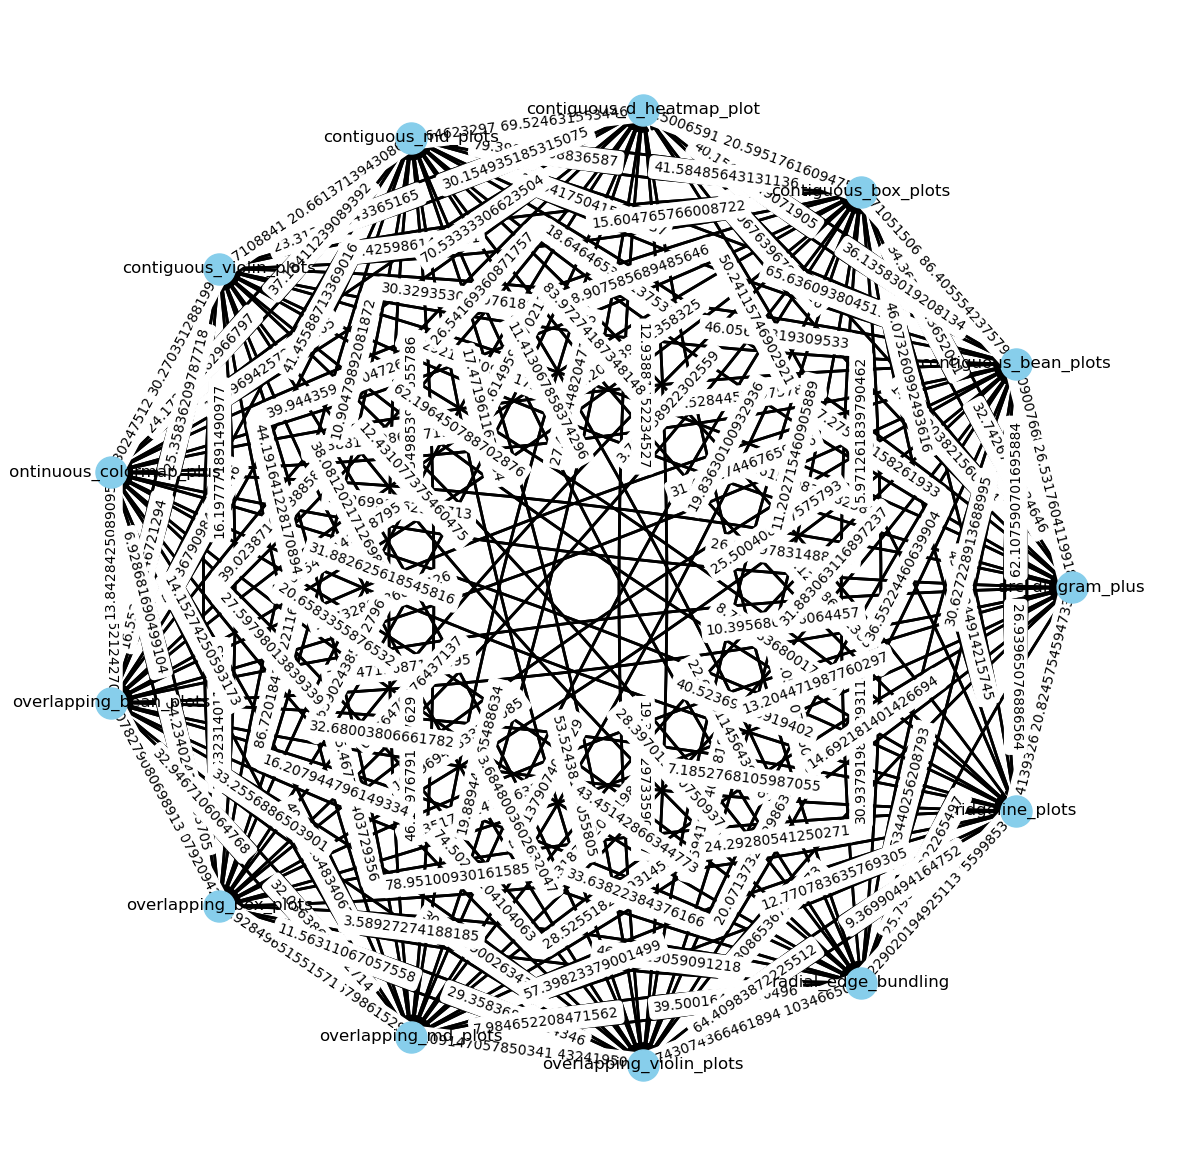

In [175]:
# select the kernel of the graph
kernel = get_kernel(G)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(15, 15))  # Adjust the size as needed

# Draw nodes
nx.draw_networkx_nodes(kernel, pos, ax=ax, node_size=500, node_color="skyblue")

curved_edges = [(u, v) for (u, v, d) in kernel.edges(data=True)]
nx.draw_networkx_edges(kernel, pos, edgelist=curved_edges, ax=ax, width=2, arrows=True, connectionstyle='arc3, rad=0.05')

# Draw edge labels with offset
edge_labels = {(u, v): d['weight'] for u, v, d in kernel.edges(data=True)}
nx.draw_networkx_edge_labels(kernel, pos, edge_labels=edge_labels, ax=ax, label_pos=0.3)

# Draw node labels
nx.draw_networkx_labels(kernel, pos, ax=ax, font_size=12, font_color="black")

# Show the plot
plt.axis('off')  # Turn off axis
plt.show()

